In [1]:
import os
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from utils.config_reader import ConfigReader
from models import get_model
from datasets.hitgraphs import HitGraphDataset, collate_fn
%matplotlib inline

In [2]:
def get_output_dir(config):
    return os.path.expandvars(config['train']['result_dir'])

def get_input_dir(config):
    return os.path.expandvars(config['train']['input_dir'])

def load_config(config_file):
    return ConfigReader(config_file).cfg

def load_summaries(config):
    summary_file = os.path.join(get_output_dir(config), 'summaries.npz')
    return np.load(summary_file)

def load_model(config, reload_epoch):
    print('loading model')
    model_config = config['model']
    model_type = model_config.pop('name')
    model_config.pop('optimizer', None)
    model_config.pop('learning_rate', None)
    model_config.pop('loss_func', None)
    model = get_model(name=model_type, **model_config)
    
    # Reload specified model checkpoint
    output_dir = get_output_dir(config)
    checkpoint_file = os.path.join(output_dir, 'checkpoints',
                                   'model_checkpoint_%03i.pth.tar' % reload_epoch)
    model.load_state_dict(torch.load(checkpoint_file, map_location='cpu')['model'])
    return model


In [3]:
config_file = '../configs/evaluate_config.yaml'

In [4]:
config = load_config(config_file)
summaries = load_summaries(config)

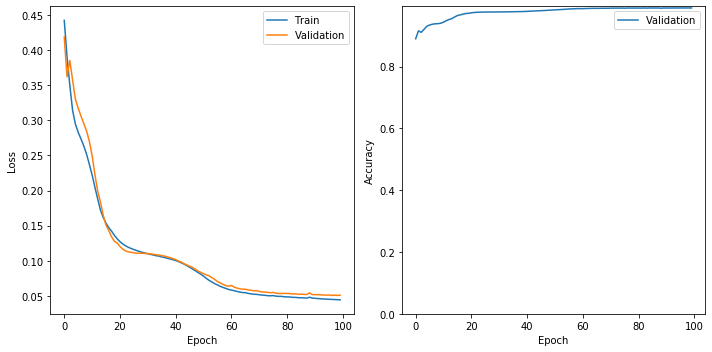

In [5]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

ax0.plot(summaries['epoch'], summaries['train_loss'], label='Train')
ax0.plot(summaries['epoch'], summaries['valid_loss'], label='Validation')
ax0.set_xlabel('Epoch', )
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, )
ax1.legend(loc=0)

plt.tight_layout()

In [6]:
model = load_model(config, reload_epoch=99).eval()

loading model


In [7]:
from utils.old_visualizer import Visualizer, draw_single
from utils.config_reader import ConfigReader
from utils.utils import get_events_df, parse_df, calc_purity_reduce_factor, apply_edge_restriction, apply_node_restriction
from utils.graph import to_nx_graph, to_line_graph, get_weight_stats, \
    get_linegraph_superedges_stat, to_pandas_graph_df, get_linegraph_stats_from_pandas, \
    get_reduced_df_graph, get_pd_line_graph, run_mbt_graph

In [77]:
cfg = {'df': {'df_path': '../data/train/CC4GeVmb_100_n50k.tsv',
              'event_ids': ['2'],
              'read_only_first_lines': 155000,
              'drop_broken_tracks': False,
              'convert_to_polar': False,
              'normalize': True,
              'stations_sizes': [[[-1.5, -4.5, 66, 41]], [[-1.5, -4.5, 66, 41]], [[-1.5, -4.5, 66, 41]], [[27.7, -4.5, 66, 41], [-34.7, -4.3, 66, 41]], [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 81.6, 45]], [[40.8, -6.9, 81.6, 45], [-40.8, -6.9, 81.6, 45]]], 'z_stations': [32.85, 65.25, 96.65, 129.35, 161.25, 193.85]}, 
       'visualize': {'draw_scatters_for_tracks': True, 
                     'mode': '2d'}, 
       'prepare': {'output_dir': '5_features_6k', 
                   'restrictions': {'x_min_max': [-0.15, 0.25], 'y_min_max': [-0.3, 0.22], 'weight_max': 0.09}}, 
       'with_stdout': False}

In [78]:
df = parse_df(cfg['df'])
event = get_events_df(cfg['df'], df, preserve_fakes=True)


In [79]:
event

,event,x,y,z,station,track
94,2,0.031479,0.610956,0.005247,0,4
95,2,0.066136,0.799493,0.205247,1,4
96,2,0.104728,0.978608,0.399074,2,4
97,2,-0.014171,0.192221,0.005247,0,10
98,2,-0.013852,0.137466,0.205247,1,10
...,...,...,...,...,...,...
389,2,-0.001648,-0.524826,0.999074,5,-1
390,2,-0.001648,-0.562152,0.999074,5,-1
391,2,-0.001648,-0.621093,0.999074,5,-1
392,2,-0.001648,-0.673890,0.999074,5,-1


In [80]:
G = to_pandas_graph_df(event)

def pandas_G_to_drawable(pandas_G, suffix='_prev'):
    return pandas_G.rename(columns={'y' + suffix:'x', 'station'+ suffix:'station'})



n_from = pandas_G_to_drawable(G, '_prev')
n_to = pandas_G_to_drawable(G, '_current')

n_from_true = n_from[(n_from.track_prev == n_from.track_current) & (n_from.track_prev != -1)]
n_from_false = n_from[(n_from.track_prev == -1) | (n_from.track_current == -1)]

n_to_true = n_to[(n_to.track_prev == n_to.track_current) & (n_to.track_prev != -1)]
n_to_false = n_to[(n_to.track_prev == -1) | (n_to.track_current == -1)]

In [81]:
def restrict_func(df):
    return apply_node_restriction(df, [-0.15, 0.25], [-0.3, 0.22])

result = get_pd_line_graph(G, with_station_info=True, restriction_func=restrict_func, reduce_output=True)

In [82]:
print("Node count:", len(event))
print("Edge count:", len(G))
print("Purity:", np.mean(result[2]))
print("Reduce factor:", np.mean(result[3]))


Node count: 300
Edge count: 6914
Purity: 0.9642857142857143
Reduce factor: 6.453059136613793


,dx,dy,x_p,x_c,y_p,y_c,dz,z,from_ind,to_ind,track,station
0,0.034657,0.188537,0.031479,0.066136,0.610956,0.799493,0.200000,0.2,94,95,4,0
2,0.044006,-0.297113,0.031479,0.075485,0.610956,0.313843,0.200000,0.2,94,104,-1,0
5,-0.045331,-0.217072,0.031479,-0.013852,0.610956,0.393884,0.200000,0.2,94,122,-1,0
6,0.002122,-0.293247,0.031479,0.033601,0.610956,0.317708,0.200000,0.2,94,128,-1,0
17,0.044006,0.102720,0.031479,0.075485,0.610956,0.713676,0.200000,0.2,94,221,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6567,0.088185,-0.195435,0.075968,0.164154,0.916695,0.721260,0.201235,1.0,278,285,-1,4
6680,-0.052803,-0.133175,0.075968,0.023165,0.681985,0.548810,0.201235,1.0,279,126,-1,4
6686,0.088185,0.039275,0.075968,0.164154,0.681985,0.721260,0.201235,1.0,279,285,-1,4
6799,0.019340,-0.284074,0.003825,0.023165,0.832884,0.548810,0.201235,1.0,280,126,-1,4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

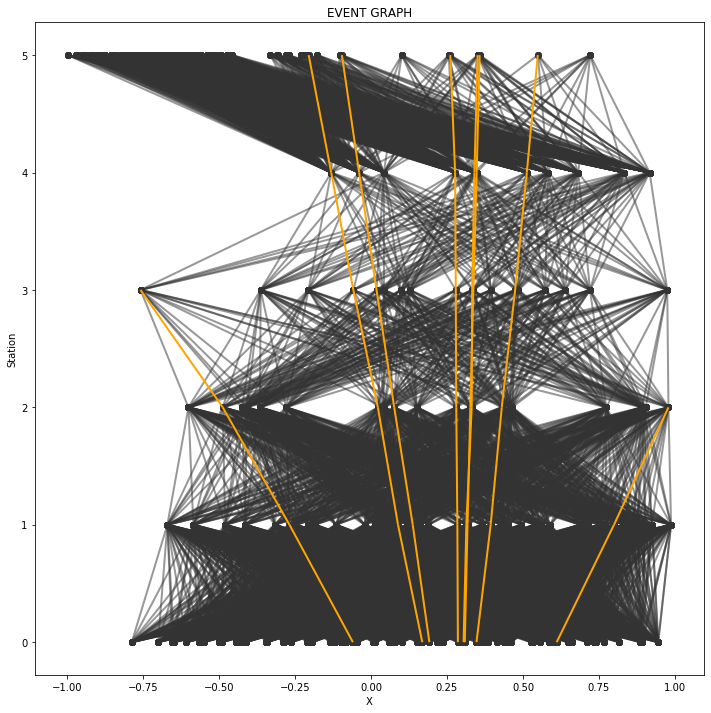

<Figure size 432x432 with 0 Axes>

In [87]:
vis = Visualizer(event, cfg['visualize'], title='EVENT GRAPH', random_seed=14)
vis.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
vis.draw_2d(ax)

vis.draw_edges_from_nodes_2d(ax, n_from_true, n_to_true, 'orange',[0.2,0.2,0.2, 0.5], 6, 0,2)
vis.draw_edges_from_nodes_2d(ax, n_from_false, n_to_false, [0.2,0.2,0.2, 0.5], [0.2,0.2,0.2, 0.5], 3, 5,2)



In [88]:
lg_full = result[1]
lg_full

,weight,true_superedge,edge_index_p,edge_index_c
0,0.010211,4,0,4067
1,0.103918,-1,0,4077
2,0.119564,-1,0,4082
3,0.229941,-1,0,4083
4,0.286075,-1,539,4067
...,...,...,...,...
8880,0.336171,-1,5560,6805
8881,0.215544,-1,5593,6799
8882,0.304398,-1,5593,6805
8883,0.405693,-1,5558,6567


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

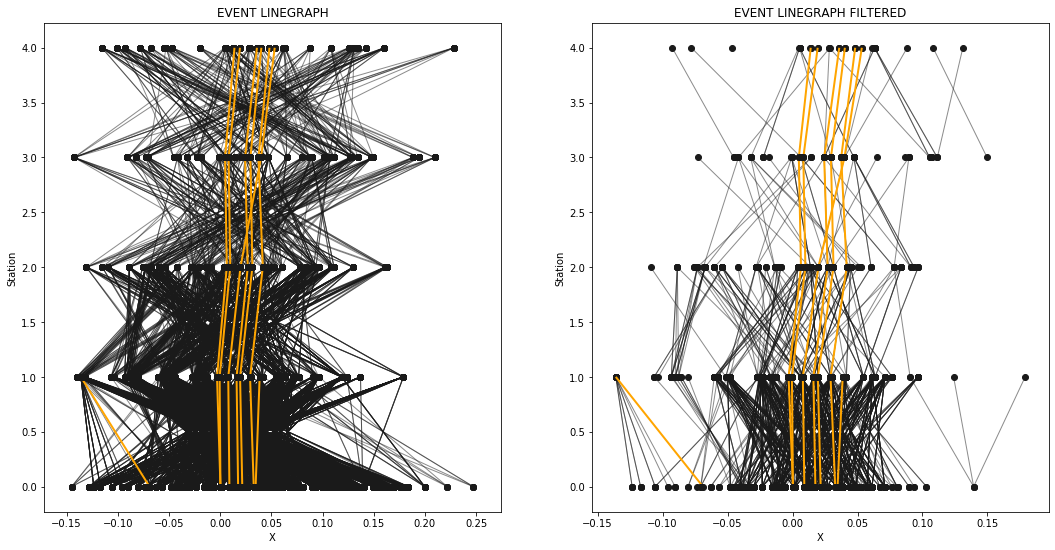

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

In [89]:
def get_like_hitgraph_from_linegraph(df):
    df = df.rename(columns={'dx':'x', 'dy':'y', 'dz':'z'})
    return df


vis = Visualizer(get_like_hitgraph_from_linegraph(result[0]), cfg['visualize'], title='EVENT LINEGRAPH', random_seed=14)
vis.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
vis.add_edges_data(lg_full)

edges_filtered = apply_edge_restriction(lg_full, 0.09)
vis1 = Visualizer(get_like_hitgraph_from_linegraph(result[0]), cfg['visualize'], title='EVENT LINEGRAPH FILTERED', random_seed=14)
vis1.init_draw(draw_all_hits=False, draw_all_tracks_from_df=False)
vis1.add_edges_data(edges_filtered)


fig = plt.figure(figsize=(18, 9))
ax0 = plt.subplot(121)
ax1 = plt.subplot(122)

ax0 = vis.draw(ax=ax0, show=False)
ax1 = vis1.draw(ax=ax1)

In [90]:
from prepare import construct_output_graph

In [91]:
output_graph = construct_output_graph(result[0], edges_filtered, ['x_p', 'x_c', 'y_p', 'y_c', 'z'])

In [92]:
output_graph

Graph(X=array([[ 0.0314789 ,  0.06613583,  0.61095566,  0.79949266,  0.2       ],
       [ 0.0314789 ,  0.0754847 ,  0.61095566,  0.3138428 ,  0.2       ],
       [ 0.0314789 , -0.01385163,  0.61095566,  0.39388394,  0.2       ],
       ...,
       [ 0.07596809,  0.16415359,  0.6819851 ,  0.7212602 ,  1.        ],
       [ 0.00382523,  0.02316478,  0.8328843 ,  0.54880995,  1.        ],
       [ 0.00382523,  0.16415359,  0.8328843 ,  0.7212602 ,  1.        ]],
      dtype=float32), Ri=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), Ro=array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=flo

In [93]:
from datasets.graph import sparse_to_graph

b_input, b_target = collate_fn([output_graph])

In [94]:
test_pred = model(b_input).flatten().detach().numpy()
test_target = b_target.flatten().detach().numpy()

In [95]:
test_target

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [104]:
thresh = 0.1
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.1
Accuracy:  0.9916
Precision: 0.7027
Recall:    1.0000


In [97]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)

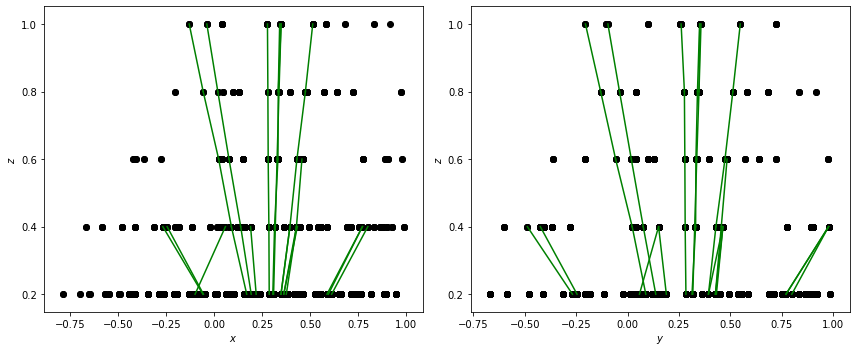

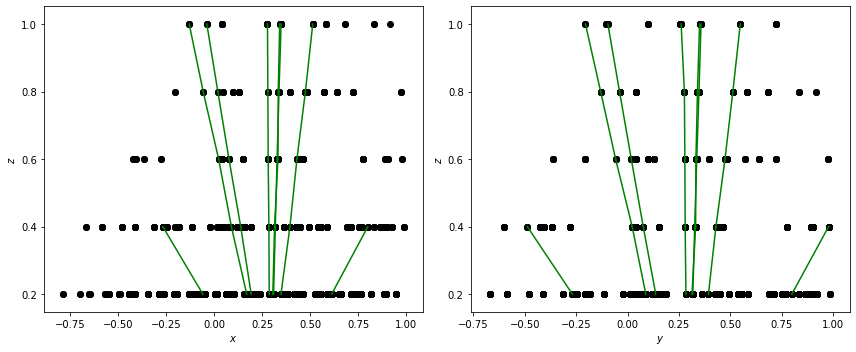

In [106]:
X, Ri, Ro, y = output_graph
draw_single(X, Ri, Ro, y_pred, c_fake=(0,0,0,0.0), xcord1=(2, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))
draw_single(X, Ri, Ro, y_true, c_fake=(0,0,0,0.0), xcord1=(2, 'x'), xcord2=(3, 'y'), ycord=(4, 'z'))
